## Auction Sale Price

Based on fastai course https://github.com/fastai

In [1]:
import sys

sys.path.insert(0, "..")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import helper as hlp

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from scipy.cluster import hierarchy
from scipy.stats import spearmanr
from pandas.api.types import is_categorical_dtype

In [3]:
data = pd.read_csv("./data/sales.csv", low_memory = False, parse_dates = ["saledate"])

In [4]:
# normalizing targets smoothing skewness
data.SalePrice = np.log(data.SalePrice)

In [5]:
# split date into relevant features
hlp.split_date(data, "saledate")

# convert non-numerical data to categorical
hlp.trans_categorical(data)

In [9]:
features, targets = hp.trans_numerical(data, "SalePrice")

In [56]:
def pred_model(train, valid, n_estimators = 10, min_samples_leaf = 1, max_features = 'auto', oob_score = False):
    ''' helper function to train and validate a model, train and valid are tuples of features and targets '''
    
    # create a random forest
    model = RandomForestRegressor(n_estimators = n_estimators, min_samples_leaf = min_samples_leaf,\
                                  max_features = max_features, oob_score = oob_score)
    
    # fit the training features and targets
    model.fit(train[0], train[1])
    
    return (model, model.score(valid[0], valid[1]))

In [57]:
train = (features, targets)

In [236]:
model, score = pred_model(train, train)

print(f"Model is heavily overfitting with {score} and won't do well on new data samples")

Model is heavily overfitting with 0.9831354460660624 and won't do well on new data samples


In [60]:
train, valid = hlp.split_data(features, targets, threshold = 1 / 12)

In [61]:
model, score = pred_model(train, valid)

print(f"Model is heavily overfitting on train set as it does {score} on unseen before samples")

Model is heavily overfitting on train set as it does 0.9059545571740466 on unseen before samples


In [62]:
model, score = pred_model(train, valid, n_estimators = 40, min_samples_leaf = 6, max_features = 0.6)

print(f"Generalizes better with {score} by early stopping, using smaller pool(features) and random subsets for training")

Generalizes better with 0.9140914124075075 by early stopping, using smaller pool(features) and random subsets for training


In [63]:
print(model.predict(valid[0][:1])[0])

10.508010992996663


In [64]:
# stacking each tree prediction with TxP => PxT
tree_scores = np.stack([ t.predict(valid[0]) for t in model.estimators_ ]).transpose()

# pool a smaller subset of results from a single prediction
tree_scores_sub = [ str(round(t, 2)) for t in tree_scores[0][:8] ]

score_mean = round(np.mean(tree_scores[0]), 5)
score_std = round(np.std(tree_scores[0]), 5)

print(", ".join(tree_scores_sub) + "...")
print(f"Trees that sees a different subset of data with higher information gain when splitting will complement\
 those that don't so well - {score_mean}, with {score_std} variance")

10.57, 10.3, 10.66, 10.35, 10.51, 10.65, 10.44, 10.57...
Trees that sees a different subset of data with higher information gain when splitting will complement those that don't so well - 10.50801, with 0.16788 variance


In [65]:
data_rt, data_rv = hlp.split_dataset(data, 12000)

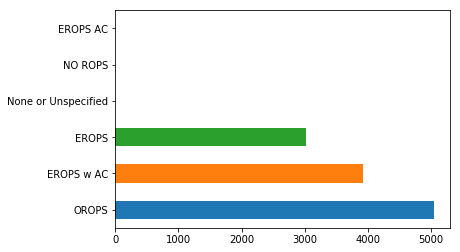

In [66]:
x = data_rv.copy()

x['Pred'] = np.mean(tree_scores, axis = 1)
x['PredDeviation'] = np.std(tree_scores, axis = 1)

x.Enclosure.value_counts().plot.barh()

In [67]:
columns = ["Enclosure", "SalePrice", "Pred", "PredDeviation"]

p = x[columns].groupby("Enclosure", as_index = False).mean()

p

,Enclosure,SalePrice,Pred,PredDeviation
0,EROPS,9.964365,10.117741,0.151257
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.726390,10.109870,0.151328
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.899330,10.107031,0.151995


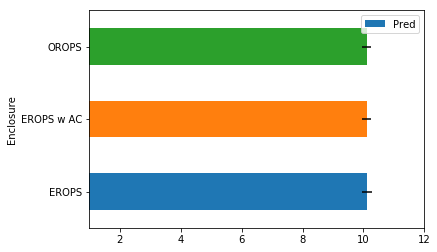

In [68]:
p[~pd.isnull(p.SalePrice)].plot("Enclosure", "Pred", "barh", xerr = "PredDeviation", xlim = (1, 12))

### Feature importance

In [199]:
def extract_feature_importances(model, columns, trim = -1, threshold = None):
    ''' helper function to extract feature importances '''
    
    # create a feature importances data frame
    feature_importances = pd.DataFrame({"columns" : columns, "importance" : model.feature_importances_})

    # descending ordering and trim
    feature_importances = feature_importances.sort_values("importance", ascending = False)[:trim]
    
    # apply filtering on unnecessary features
    if(threshold is not None):
        feature_importances = feature_importances[feature_importances.importance > threshold]
    
    return feature_importances

In [70]:
# extracting feature importances
feature_importances = extract_feature_importances(model, train[0].columns, threshold = 0.002)

feature_importances.head(n = 6)

,columns,importance
5,YearMade,0.172716
37,Coupler_System,0.134295
13,ProductSize,0.105016
14,fiProductClassDesc,0.094541
2,ModelID,0.069353
54,sale_timestamp,0.058043


In [71]:
def print_feature_importances(features, figsize = (10, 7), title = "Feature importances"):
    ''' helper function to print feature importances with bar plot '''
    
    # figure size
    plt.figure(figsize = figsize)
    
    # figure title
    plt.title(title)
    
    # supplying bars' width
    plt.barh(range(len(features)), features["importance"], color = "c", align = "center")
    
    # setting up y axis labels
    plt.yticks(range(len(features)), features["columns"])
    
    # setting up limits for y axis
    plt.ylim([-1, len(features)])
    
    plt.show()

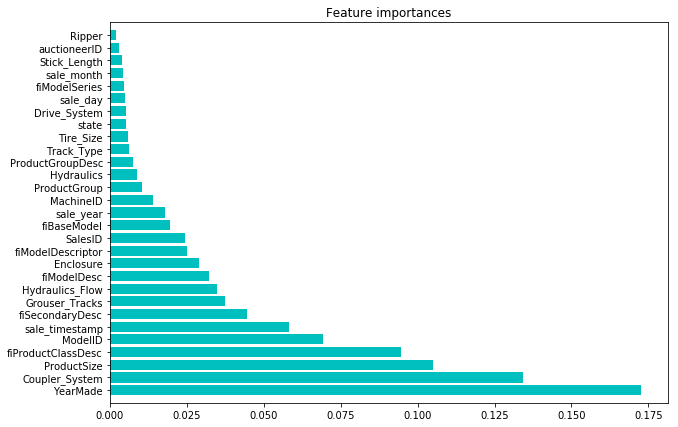

In [72]:
print_feature_importances(feature_importances)

In [343]:
def model_validate(features, targets, threshold = 1 / 12, columns = None, n_estimators = 40, min_samples_leaf = 6):
    ''' simple helper function to make model validation faster '''
    
    # standard parameters 
    max_features = 0.6

    # extracting train and validation set with filtered columns based on importance 
    train, valid = hlp.split_data(features, targets, threshold = threshold, columns = columns)

    # re-run model training
    model, score = pred_model(train, valid, n_estimators = n_estimators,\
                                    min_samples_leaf = min_samples_leaf, max_features = max_features, oob_score = True)
    
    return model, score

In [134]:
# re-run model training
mode, score = model_validate(features, targets, threshold = 1 / 12, columns = feature_importances["columns"])

print(f"Less redunant data result in less chance to get snagged into a split that would become less\
 significant as more splits will become redundant - {round(score, 6)}")

Less redunant data result in less chance to get snagged into a split that would become less significant as more splits will become redundant - 0.916044


### Removing redundant features

In [135]:
def generate_feature_dependencies(features, columns = None):
    ''' helper function to extract feature dependencies by clustering '''

    # make copy
    features_filtered = features.copy()
    
    # filter columns
    if(columns is not None):
        features_filtered = features_filtered[columns]

    # calculate correlations between different columns
    correlation = spearmanr(features_filtered).correlation

    # compute clusters based on average distance
    clusters = hierarchy.linkage(correlation, method = 'average')

    # explicitly set bigger size
    fig = plt.figure(figsize = (28, 14))
    
    # generate a dendrogram
    hierarchy.dendrogram(clusters, labels = features_filtered.columns, orientation = 'right', leaf_font_size = 18)

    # show plot
    plt.show()
    
    return (clusters, features_filtered)

def validate_dependency(columns):
    ''' helper function returning a fn that computes score of dataset minus one feature '''
    
    def validator(column_index):

        # new columns filtered
        columns_filtered = columns[:column_index] + columns[column_index + 1:]

        # extracting train and validation set with filtered columns based on importance 
        train, valid = hlp.split_data(features, targets, threshold = 1 / 12, columns = columns_filtered)

        # re-run model training
        model, score = pred_model(train, valid, n_estimators = 10, min_samples_leaf = 15,\
                                  max_features = 0.5)

        return score
    
    return validator

def extract_cluster_partition(clusters, index, part):
    # feature partition index
    feature_part_index = int(clusters[index][part])
       
    # features partition node
    if(feature_part_index < len(clusters) + 1):
        return [ feature_part_index ]
    else:
        return extract_cluster_entities(clusters, feature_part_index % (len(clusters) + 1))

def extract_cluster_entities(clusters, index):
    ''' helper function that breaks down compound cluster to an array of features/columns
        
        clusters[0] is referenced by len(clusters) + 1 index
        clusters[1] is referenced by len(clusters) + 2 index
        ...
        
        # assuming
        
        clusters[2] = [len(clusters) + 1, len(clusters) + 2] <=> [ * clusters[0], * clusters[1] ]
    '''

    return [ 
        * extract_cluster_partition(clusters, index, 0), 
        * extract_cluster_partition(clusters, index, 1)
    ]

def extract_relevant_dependencies(features, clusters, threshold, show = False):
    ''' helper function to remove feature dependencies by a threshold '''

    # make copy
    features_filtered = features.columns

    # extracting unnecessary clusters, 2nd dimen 0-1 columns are similar clusters, filtering by distance 2nd col
    clusters_filtered = clusters[clusters[:, 2] < threshold][:, :2].astype(dtype = "int32")

    # expanding each compound cluster to a list of entities that makes up the cluster
    clusters_filtered = [ extract_cluster_entities(clusters, index) for index, cluster in enumerate(clusters_filtered) ]
    
    # our validator function for finding which feature within the cluster to be kept
    validator = validate_dependency(features_filtered.values.tolist())
    
    # unnecessary features that are correlated with its siblings within their cluster
    columns_filtered = []
    
    for cluster in clusters_filtered:
        
        # filter already processed features within compound cluster with 3 and more features
        cluster = [ feature for feature in cluster if feature not in columns_filtered ]
        
        # we'll have always a tuple
        if len(cluster) != 2: 
            raise Exception(f"Illegal number of features, got {len(cluster)}")
        
        # compute accuracy with each feature removed one at once from the dataset
        validators = [ validator(feature) for feature in cluster ]
        
        # retrieve the one that is the most uncertain when describing our dataset
        feature_index = cluster[int(validators[0] > validators[1])]
        
        # this one will be kept
        feature_kept_index = features_filtered[cluster[(feature_index + 1) % 2]]
        
        # update our filtered features
        columns_filtered.append(feature_index)
        
        # distance score 
        features_score = -abs(validators[0] - validators[1])
        
        print(f"{features_filtered[feature_index]} is less potent then {feature_kept_index}: {features_score}")
        
    # mapping feature indices to their column name
    columns_filtered = [ features_filtered[feature_index] for feature_index in columns_filtered ]
    
    if(show):
        
        # show them
        print(f"Non relevant features: " + " ".join(columns_filtered))

    # discarding columns
    features_filtered = [f for f in features_filtered if f not in columns_filtered]
    
    return features_filtered

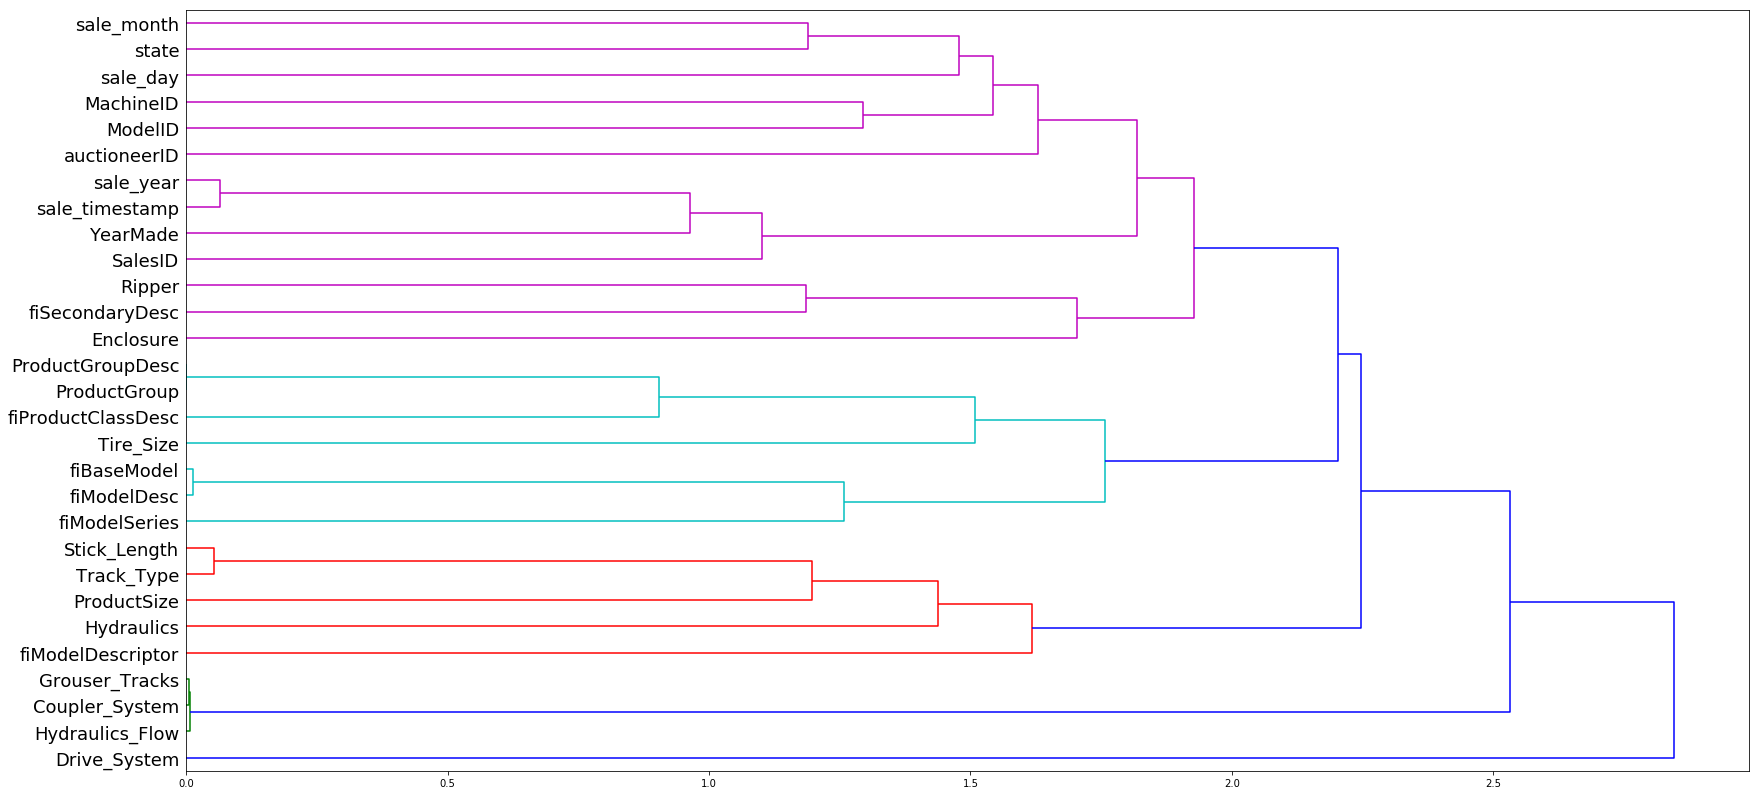

In [136]:
clusters, features_filtered = generate_feature_dependencies(features, columns = list(feature_importances["columns"]))

In [137]:
features_relevant = extract_relevant_dependencies(features_filtered, clusters, 0.03, show = True)

ProductGroup is less potent then ProductGroupDesc: -0.0013679042378045292
Grouser_Tracks is less potent then Coupler_System: -8.004012511442227e-06
Hydraulics_Flow is less potent then Coupler_System: -0.001451929083140624
fiBaseModel is less potent then fiModelDesc: -0.000349009038678294
Non relevant features: ProductGroup Grouser_Tracks Hydraulics_Flow fiBaseModel


In [202]:
# re-run model training
model, score = model_validate(features, targets, threshold = 1 / 12, columns = features_relevant)

print(f"Discarding unnecesary correlated features and re-running model training - {round(score, 6)}")

Discarding unnecesary correlated features and re-running model training - 0.915697


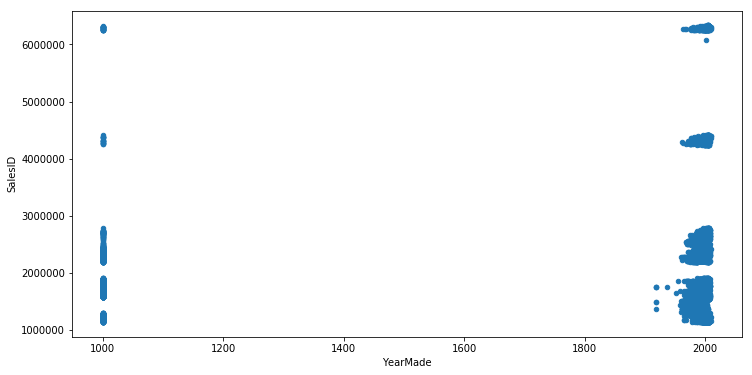

In [139]:
features.head(20000).pleot('YearMade', 'SalesID', 'scatter', figsize = (12, 6));

In [158]:
# feature YearMade adds noise when equal to 1000
features_noise = features["YearMade"] < 1930

# compute mean as gap between YearMade and sale_year
features_mean = np.mean(features[~features_noise]["sale_year"] - features[~features_noise]["YearMade"])

# updated copy of features
features_c = features.copy()

# updating YearMade with normalized values 
features_c["YearMade"][features_noise] = features[features_noise]["sale_year"] - features_mean

# creating a new feature Age
features_c["Age"] = features["sale_year"] - features["YearMade"]

# updating relevant features
features_relevant += ["Age"]

print(f"Mean gap between Year Made and Sale Year: {features_mean}")

Mean gap between Year Made and Sale Year: 10.19240013671595


C:\Users\Cchiv\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [192]:
# re-run model training
model, score = model_validate(features_c, targets, threshold = 1 / 12, columns = features_relevant)

print(f"Removing noise from dataset - {round(score, 6)}")

Removing noise from dataset - 0.915877


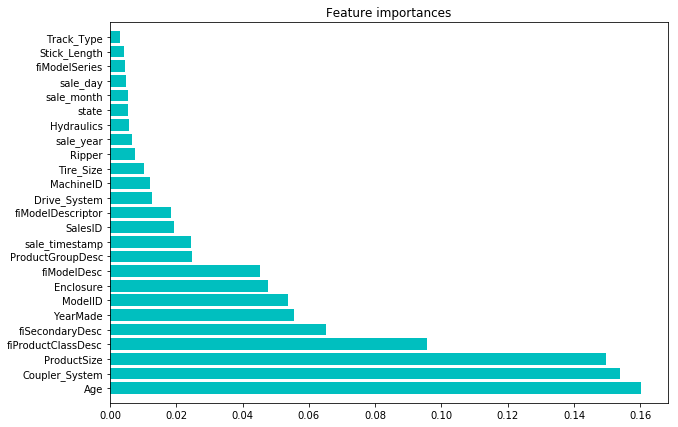

In [201]:
# extracting feature importances
feature_importances_c = extract_feature_importances(model, features_relevant, threshold = None)

print_feature_importances(feature_importances_c)

### Extrapolation

The idea is that we are trying to classify a random variable where independent features as keys(ids) will always perform better due to their uniqueness and zero penalty during classification learning process, as P(y = target | id) = 1.0, where for our regression analysis, little does it matter when dealing with unique keys.

In [ ]:
# copy data and keep relevant features
data_c = data.copy()[features_relevant]

# create class feature for classification 
data_c["class"] = 1

# assign a small subset with contradictory value
data_c["class"][:75000] = 0

In [318]:
features_a, targets_a = hp.trans_numerical(data_c, "class")

In [319]:
# re-run model training with training and validation set consisting of "class" feature
model_a = RandomForestClassifier(n_estimators = 40,\
                                min_samples_leaf = 3, max_features = 0.6, oob_score = True)

model_a.fit(features_a, targets_a)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.6, max_leaf_nodes=3,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [327]:
print(f"Score - {round(model_a.oob_score_, 6)}")

Score - 0.998714


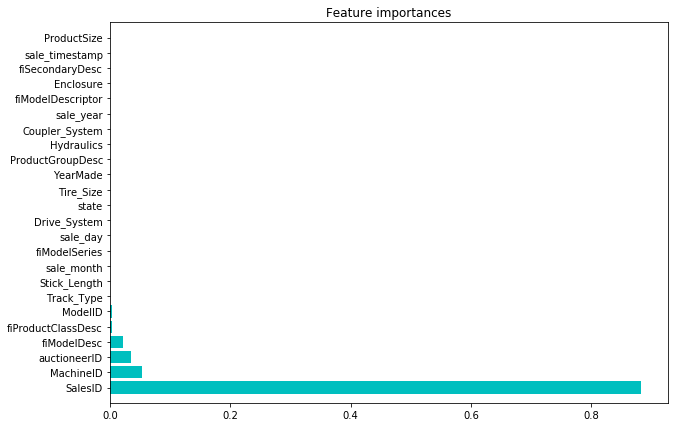

In [328]:
# extracting the most important features
feature_importances_a = extract_feature_importances(model_a, features_a.columns, threshold = None)

print_feature_importances(feature_importances_a)

In [335]:
# filter way too random features
features_random = feature_importances_a[feature_importances_a["importance"] > 0.02]

features_random

,columns,importance
10,SalesID,0.883518
12,MachineID,0.053126
23,auctioneerID,0.034329
7,fiModelDesc,0.020914


In [339]:
for feature_random in features_random["columns"]:
    
    # updating relevant features
    features_relevant_r = [ feature for feature in features_relevant if not feature == feature_random ]
    
    # re-run model training
    model, score = model_validate(features_c, targets, threshold = 1 / 12, columns = features_relevant_r)

    print(f"Removing feature {feature_random} with score - {round(score, 6)}")

Removing feature SalesID with score - 0.916219
Removing feature MachineID with score - 0.916301
Removing feature auctioneerID with score - 0.914252
Removing feature fiModelDesc with score - 0.913211


In [340]:
# updating our relevant features
features_relevant_r = [ feature for feature in features_relevant if feature not in ["SalesID", "MachineID"] ]

### Final Model

In [349]:
# re-run model training one last time
model, score = model_validate(features, targets, threshold = 1 / 12, columns = features_relevant,\
                              n_estimators = 120, min_samples_leaf = 3)

print(f"Final score - {round(score, 6)}")

Final score - 0.920273
